# TOV Solver -- piecewise equation of state

In [1]:
import numpy as np
from scipy.integrate import solve_ivp, odeint, quad
from astropy.constants import G, c
from numpy import pi
import astropy.units as u
import matplotlib.pyplot as plt
import sys
import math
np.set_printoptions(threshold=sys.maxsize)
from scipy import optimize
from sympy import symbols, diff

In [2]:
# Using natural units
# 197 MeV * fm = 1
# 1 fm = 1 / (197 MeV)
# 3e8 m = 1 s
# 3e8 m / s = 1
# 1 J = 1 kg * (m / s)^2
# 1 J = 1 / 9e16 kg

natural = [(u.MeV, u.fm ** (-1), lambda fm_inverse: 1 / 197 * fm_inverse, lambda MeV: 197 * MeV),
           (u.m, u.s, lambda s: 1 / c.value * s, lambda m: c.value * m),
           (u.kg, u.J, lambda J: c.value ** 2 * J, lambda kg: 1 / c.value ** 2 * kg),
           (u.m / u.s, u.dimensionless_unscaled, lambda dimensionless: 1 / c.value * dimensionless, lambda v: c.value * v),
           (u.fm, u.MeV ** (-1), lambda MeV_inverse: 1 / 197 * MeV_inverse, lambda fm: 197 * fm)
          ]

G = (G.value * (1 * u.m / u.s).to(u.dimensionless_unscaled, equivalencies = natural) ** 2 * (1 * u.m).to(u.fm).to(1 / u.MeV, equivalencies = natural) / (1 * u.kg).to(u.J, equivalencies = natural).to(u.MeV))
G = G.value

### Initial condition - central mass density

In [3]:
# Everything in natural units unless otherwise specified
# r_small cannot be 0 b/c it would cause a singularity.

small_r = (0.1 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value
m_N = 939.565 * u.MeV    # Natural units
n_0 = 0.16 / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3    # Nuclear saturation density

# Setting nuclear parameters
a = 13.0 * u.MeV
alpha = 0.49
b = 3.21 * u.MeV
beta = 2.47

# Setting critical energy density corresponding to n_0 for piece-wise EoS
epsilon_c_value = 150    # In MeV / fm^3
epsilon_c = epsilon_c_value * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3

# Piecewise EoS parameters
epsilon_delta_value = 618.367    # In MeV / fm^3
epsilon_delta = epsilon_delta_value * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
c_s_upper = 1.0

### Setting central cumulative mass initial condition

In [4]:
def M_from_r_and_rho(r, rho):
    result = 4 * pi * rho * r ** 3 / 3
    return result

### Horizontal axis scale

In [5]:
# Everything in natural units unless otherwise specified

R_attempt = (100 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value

## Functions to find numerical EoS arrays given some number density (in natural units)

In [6]:
# Non-rest-mass energy E
def find_E(num_density):
    result = a * (num_density / n_0) ** alpha + b * (num_density / n_0) ** beta
    return result

# Energy density epsilon
def find_epsilon(num_density):
    E = find_E(num_density)
    result = num_density * (E + m_N)
    return result

# Chemical potential
def find_chem_potential(num_density):
    result = a * (alpha + 1) * (num_density / n_0) ** alpha + b * (beta + 1) * (num_density / n_0) ** beta + m_N
    return result

# Pressure
# Using epsilon_delta = 618.367 MeV / fm^3 and c_s_upper = 1.0
def find_pressure(num_density):
    epsilon = find_epsilon(num_density)
    chem_potential = find_chem_potential(num_density)
    num_density_c = num_density_from_energy_density(epsilon_c.value) * u.MeV ** 3
    chem_potential_c = find_chem_potential(num_density_c)
    pressure_c = - epsilon_c + chem_potential_c * num_density_c
    
    # Piece-wise extremal EoS
    if epsilon.value < epsilon_c.value:
        result = - epsilon + chem_potential * num_density    # Gandolfi nuclear EoS
    else:
        if epsilon.value < epsilon_delta.value:
            result = pressure_c    # Flat EoS
        else:
            result = pressure_c + c_s_upper * (epsilon - epsilon_delta)    # EoS slope = c_s_upper
    
    return result

In [7]:
# Finding number density as a function of energy density

def energy_density_minus_target_epsilon(n, target_epsilon):
    n = n * u.MeV ** 3
    result = find_epsilon(n).value - target_epsilon
    return result

# Takes input parameter epsilon in MeV^4
def num_density_from_energy_density(epsilon):
    b = 10 ** 12
    if energy_density_minus_target_epsilon(0, epsilon) > 0:
        print(f"find_epsilon is {find_epsilon(0 * u.MeV ** 3)} and epsilon is {epsilon}.")
        return
    result = optimize.brentq(energy_density_minus_target_epsilon,
                             0,
                             b,
                             args = (epsilon,))
    return result

In [8]:
# Finding number density as a function of pressure

def pressure_minus_target_p(n, target_p):
    n = n * u.MeV ** 3
    result = find_pressure(n).value - target_p
    return result

def find_pressure_brentq_b(n_central):
    slope = (0.125 * 10 ** 8) / n_0.value
    intercept = 10 ** 8 - slope * 8 * n_0.value
    result = slope * n_central + intercept
    return result

def num_density_from_pressure(p, r, n_central):
    if pressure_minus_target_p(0, p) > 0:
        print(f"Distance from center is {(r / u.MeV).to(u.fm, equivalencies = natural).to(u.km)}, w/ find_pressure {find_pressure(0 * u.MeV ** 3)} and p {p}.")
        return

    pressure_brentq_b = find_pressure_brentq_b(n_central)
    
    result = optimize.brentq(pressure_minus_target_p,
                             0,
                             pressure_brentq_b,
                             args = (p,)
                            )
    
    return result

## Plotting EoS

In [9]:
epsilon = []
pressure = []

n = np.logspace(-1, 1, num = 200) * n_0

for num_density in n:
    epsilon_in_MeV = find_epsilon(num_density).value
    epsilon_in_MeV_and_fm = epsilon_in_MeV * u.MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
    epsilon.append(epsilon_in_MeV_and_fm.value)
    pressure_in_MeV = find_pressure(num_density).value
    pressure_in_MeV_and_fm = pressure_in_MeV * u.MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
    pressure.append(pressure_in_MeV_and_fm.value)

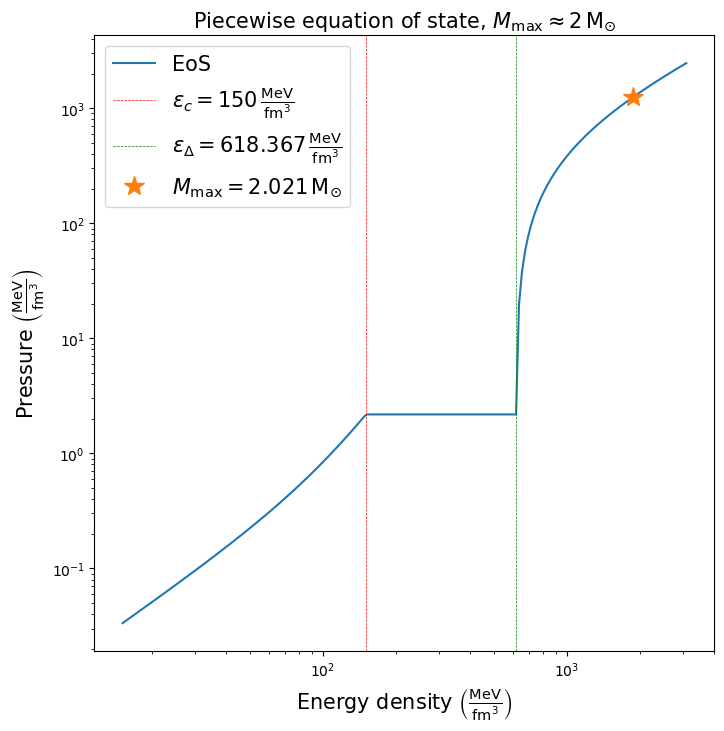

In [51]:
fig, ax = plt.subplots(figsize = (8, 8))

ax.set_title(r"Piecewise equation of state, $M_{\mathrm{max}}\approx2\,\mathrm{M}_{\odot}$",
             fontsize = 15
            );

ax.set_xlabel(r"Energy density $\left(\frac{\mathrm{MeV}}{\mathrm{fm}^3}\right)$", fontsize = 15);
ax.set_ylabel(r"Pressure $\left(\frac{\mathrm{MeV}}{\mathrm{fm}^3}\right)$", fontsize = 15);
ax.plot(epsilon, pressure, label = "EoS");

ax.axvline(x = epsilon_c_value,
           color = "red",
           linestyle = "--",
           linewidth = 0.5,
           label = r"$\epsilon_{c}=150\,\frac{\mathrm{MeV}}{\mathrm{fm}^3}$"
          );

ax.axvline(x = epsilon_delta_value,
           color = "green",
           linestyle = "--",
           linewidth = 0.5,
           label = r"$\epsilon_{\Delta}=618.367\,\frac{\mathrm{MeV}}{\mathrm{fm}^3}$"
          );

# Maximum mass critical point found from mass-radius curve
# In MeV / fm^3, rounded to 3 significant figures.
epsilon_max = 1870
pressure_max = 1260

ax.plot(epsilon_max,
        pressure_max,
        marker = "*",
        linestyle = "",
        markersize = 15,
        label = r"$M_{\mathrm{max}}=2.021\,\mathrm{M}_{\odot}$"
       );

ax.loglog();
ax.legend(fontsize = 15);

plt.savefig("piecewise_EoS_epsilon_D_618.jpg", bbox_inches = "tight");
plt.savefig("piecewise_EoS_epsilon_D_618.pdf", bbox_inches = "tight");

## Generalized TOV

In [11]:
# r = distance from center
# m = cumulative mass enclosed within distance r from center
# p = pressure at distance r from center
# epsilon = energy density at distance r from center

# TOV and EoS coded to be compatible w/ cgs units, but can't explicitly give units in code b/c solve_ivp() throws errors

def TOV(r, p_and_m, n_central):
    p = p_and_m[0]
    m = p_and_m[1]
    if num_density_from_pressure(p, r, n_central) is None:
        return [0, 0]
    n = num_density_from_pressure(p, r, n_central) * u.MeV ** 3
    epsilon = find_epsilon(n).value
    print(f"number density is {n}")
    rel_factors = (1 + p / epsilon) * (1 + 4 * pi * r ** 3 * p / m) * (1 - 2 * G * m / r) ** (-1)
    p_result = - G * epsilon * m / r ** 2 * rel_factors
    m_result = 4 * pi * r ** 2 * epsilon
    return [p_result, m_result]

### TOV solver function

In [12]:
# Keep this for all EoS

def solve_TOV(n_central, p_central):
    epsilon_central = find_epsilon(n_central * u.MeV ** 3).value
    m_central = M_from_r_and_rho(small_r, epsilon_central)
    
    def reached_surface(t, y, *args):
        return y[0]

    reached_surface.terminal = True
    reached_surface.direction = -1
    
    solution = solve_ivp(TOV,
                         [small_r, R_attempt],
                         [p_central, m_central],
                         events = reached_surface,
                         args = (n_central,)
                        )

    distance_from_center = (solution.t / u.MeV).to(u.fm, equivalencies = natural).to(u.km)
    print(f"Mass is {(solution.y[1][-1] * u. MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass):.3f}.")
    cumulative_mass = (solution.y[1] * u.MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass)
    pressure = solution.y[0]

    result = distance_from_center, cumulative_mass, pressure
    return result

## Making mass-radius plot

In [13]:
mass = []
radius = []
pressure_list = []

# Nuclear saturation number density is 0.16 fm^(-3)
n_central = np.logspace(-0.3, 1, num = 50) * n_0

for num_density in n_central:
    p_central = find_pressure(num_density).value
    distance_from_center, cumulative_mass, pressure_values = solve_TOV(num_density.value, p_central)
    print("Solved TOV")

    # Removing NaN and inf values from cumulative mass
    
    cumulative_mass = cumulative_mass[~np.isnan(cumulative_mass)]
    cumulative_mass = cumulative_mass[~np.isinf(cumulative_mass)]
        
    mass.append(cumulative_mass[-1].value)
    radius.append(distance_from_center[-1].value)
    pressure_list.append(pressure_values[0])

number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269818 MeV3
number density is 613082.1350269796 MeV3
number density is 613082.1350269796 MeV3
number density is 613082.1350269796 MeV3
number density is 613082.1350269796 MeV3
number density is 613082.1350269796 MeV3
number density is 613082.1350269762 MeV3
number density is 613082.135026978 MeV3
number density is 613082.1350269723 MeV3
number density is

In [14]:
mass = mass * u.solMass
radius = radius * u.km
print(mass, radius)

[0.09383706 0.09742026 0.10152724 0.10615487 0.11124274 0.11736203
 0.12418005 0.13209067 0.14121029 0.15148874 0.16396128 0.17730756
 0.17726149 0.17725644 0.17726325 0.17726125 0.17725394 0.17671083
 0.17720195 0.17724432 0.17728808 0.17733211 0.17738684 0.17744078
 0.17749835 0.177638   0.17762036 0.17768916 0.17715338 0.17711926
 0.17712774 0.17712551 0.17710698 0.13575563 0.59365515 0.98999819
 1.28681303 1.50470516 1.6646073  1.78291654 1.86864994 1.93040814
 1.9756989  2.00234433 2.0165476  2.02073371 2.01609127 2.00443206
 1.98696262 1.96402449] solMass [14.11840791 13.83749105 13.54614472 13.235426   12.8767898  12.74527448
 12.48215971 12.22528104 12.09292508 11.76494698 11.79951589 11.46521099
 11.43422837 11.43996951 11.4363529  11.42691442 11.43775941 11.31215136
 11.45541257 11.47908446 11.46492939 11.46333973 11.5321946  11.54545658
 11.56137423 11.67040002 11.60578231 11.61987858 11.43751086 11.39799152
 11.42258385 11.42871545 11.43570255  7.55837834  7.37275978  8.061

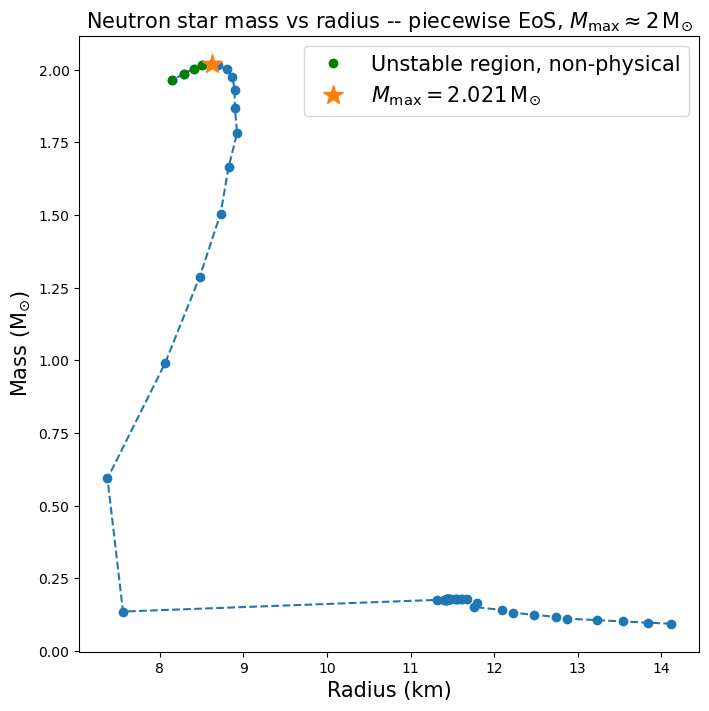

In [55]:
fig, ax = plt.subplots(figsize = (8, 8))

ax.set_title(r"Neutron star mass vs radius -- piecewise EoS, $M_{\mathrm{max}}\approx2\,\mathrm{M}_{\odot}$",
             fontsize = 15
            );

ax.set_xlabel("Radius (km)", fontsize = 15);
ax.set_ylabel(r"Mass ($\mathrm{M_{\odot}}$)", fontsize = 15);
ax.plot(radius, mass, "--o");

# Maximum mass critical point found from mass-radius curve
# In km and solar masses respectively, rounded to the thousandths place
radius_max = 8.629
mass_max = 2.021

ax.plot(radius[-4:], mass[-4:], marker = "o", color = "g", linestyle = "", label = "Unstable region, non-physical");

ax.plot(radius_max,
        mass_max,
        marker = "*",
        linestyle = "",
        markersize = 15,
        label = r"$M_{\mathrm{max}}=2.021\,\mathrm{M}_{\odot}$"
       );

ax.legend(fontsize = 15);

plt.savefig("piecewise_mass_radius_plot_epsilon_D_618.pdf", bbox_inches = "tight");
plt.savefig("piecewise_mass_radius_plot_epsilon_D_618.jpg", bbox_inches = "tight");

In [40]:
index = np.where(mass == np.max(mass))[0][0]
print(f"Maximum mass is {np.max(mass)}, radius is {radius[index]}, n_central is {n_central[index]}, and p_central is {pressure_list[index]}.")

Maximum mass is 2.020733710103771 solMass, radius is 8.628664981215271 km, n_central is 9580677.296029927 MeV3, and p_central is 9595530603.089584.


In [42]:
n_central_max = 9580677.296029927 * u.MeV ** 3
epsilon_max = find_epsilon(n_central_max).value * u.MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
pressure_max = find_pressure(n_central_max).value * u.MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
print(f"Energy density that yields the maximum mass is {epsilon_max:.0f} and pressure that yields the maximum mass is {pressure_max:.0f}.")

Energy density that yields the maximum mass is 1871 MeV / fm3 and pressure that yields the maximum mass is 1255 MeV / fm3.


In [27]:
index_2 = 43
print(f"Mass around 2 is {mass[index_2]}, radius is {radius[index_2]}, n_central is {n_central[index_2]}, and p_central is {pressure_list[index_2]}.")

Mass around 2 is 2.0023443258681297 solMass, radius is 8.797363175527241 km, n_central is 8478811.646151397 MeV3, and p_central is 6788331987.224203.


In [37]:
n_central_2 = 8478811.646151397 * u.MeV ** 3
epsilon_2 = find_epsilon(n_central_2).value * u.MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
pressure_2 = find_pressure(n_central_2).value * u.MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
print(f"Energy density that yields 2 solar masses is {epsilon_2:.0f} and pressure that yields 2 solar masses is {pressure_2:.0f}.")

Energy density that yields 2 solar masses is 1504 MeV / fm3 and pressure that yields 2 solar masses is 888 MeV / fm3.
